# Bayesian Structural Time Series 

<br>
<img align="left" width="60" height="200" src="https://img.shields.io/badge/R-v3.5.0-green.svg">
<br>

### Notebook by [Marco Tavora](http://www.marcotavora.me)


## Table of contents

1. [Motivation](#Motivation)

1. [Executive Summary of the BSTS Technique](#Executive-Summary-of-the-BSTS-Technique)

## Motivation
[[go back to the top]](#Table-of-contents)

Let us try to estimate the impact of the [Deepwater Horizon oil spill](https://en.wikipedia.org/wiki/Deepwater_Horizon_oil_spill) on [BP plc](https://en.wikipedia.org/wiki/BP) (formerly British Petroleum) stock prices using Bayesian structural time series [Sengul (2018)](#References) (see section [BSTS Model](#BSTS-Model) for a slightly more formal explanation). 

### The oil was photographed from space by a NASA satellite in 24 May of 2010 and is [shown below](https://en.wikipedia.org/wiki/Deepwater_Horizon_oil_spill)

<br>
<p align="center">
  <img src="oil-spill.jpg" 
       width="600">
<br>

## Executive Summary of the BSTS Technique
[[go back to the top]](#Table-of-contents)

In general, structural time series (STS) models (either frequentist or Bayesian) can be written as a system of equations. The simplest possible example of STS model is the *local level model*, given by:

$$\begin{array}{l}
{\mu _{t + 1}} = {\mu _t} + {\xi _t},\\
{y_t} = {\mu _t} + {\varepsilon _t}
\end{array}$$

where ${\xi _t} \sim {\cal N}(0,\sigma _\xi ^2)$ and ${\varepsilon _t} \sim {\cal N}(0,\sigma _\varepsilon ^2)$.
Here, the first equation is called *state equation* and ${\mu _t}$ is an unobserved variable. Though ${\mu _t}$ is not observed, the second equation, called *observation equation*, which depends on ${\mu _t}$, contains the variable ${y_t}$ which is based on observed data (roughly speaking, ${\mu _t}$ can be interpreted as a time-dependent version of the intercept of simple linear regressions).

The general form of the BSTS is more convoluted so let us consider the following case,  

$$\begin{array}{l}
{y_t} = {\mu _t} + {\tau _t} + {\beta ^T}{{\vec x}_t} + {\varepsilon _t}\\
{\mu _t} = {\mu _{t - 1}} + {\delta _{t - 1}} + {\eta _t},\,\,\,\,\,\,\,\,\,\\
{\delta _t} = {\delta _{t - 1}} + {\omega _t},\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\\
{\tau _t} =  - \sum\nolimits_{s = 1}^{S - 1} {{\tau _{t - s}} + {\gamma _t}} 
\end{array}$$

where the errors have similar properties as in the local level model. The variables have the following meanings:
- ${\tau _t}$ is the seasonal component
- ${\delta _t}$ is a random walk with trend
- ${\mu _t}$ is the trend component
- ${{\vec x}_t}$ is a vector of covariates.

The last variable, namely, ${{\vec x}_t}$ is of crucial importance in this discussion. It is a vector time series that can be used to predict ${y_t}$ and the coefficients $\beta$ are estimated the [spike-and-slab](https://projecteuclid.org/download/pdfview_1/euclid.aos/1117114335) Bayesian method of feature selection. To use this system of equations to predict BP stock prices after the oil spill we need to identify seasonal effects, trends and choose ${{\vec x}_t}$. An important condition that must be obeyed is that ${{\vec x}_t}$ must (ideally) be highly correlated with ${y_t}$, but cannot have been impacted by the same factors that impacted $y_t$.

Let us apply the `CausalImpact` package without going into much detail now. First let us build 

## Installing packages

[[go back to the top]](#Table-of-contents)

Some of the packages we need to install are:

- `devtools` to be able to download packages from Github
- `magrittr` for code readability and maintainability
- `dplyr` for data manipulation
- `rga` to obtain data from the Google Analytics (GA) APIs

We need also to provided the `id` corresponding to our view from GA.

In [107]:
# # install.packages("devtools")
# # install.packages("magrittr")
# # install.packages("dplyr")
# # install.packages("curl")
# # install_github("skardhamar/rga")
# # install.packages(c("bitops", "jsonlite", "httr"),repos='http://cran.us.r-project.org')
# install.packages("tidyverse")
# install.packages("tidyr")

In [17]:
library(devtools)
library(magrittr)
library("dplyr")
library(lubridate)
library(curl)
library(tidyverse)
library(tidyr)

Reading the `csv` file containing the BP stock prices:

In [187]:
stocks <- read.csv('stocks.csv')
head(stocks)

date,bp,nasdaq
2009-01-02,47.0,15.79
2009-01-05,48.3,16.21
2009-01-06,48.9,16.42
2009-01-07,48.0,16.22
2009-01-08,48.3,15.90
2009-01-09,47.9,16.17


The oil spil date is indicated by the dashed vertical line.

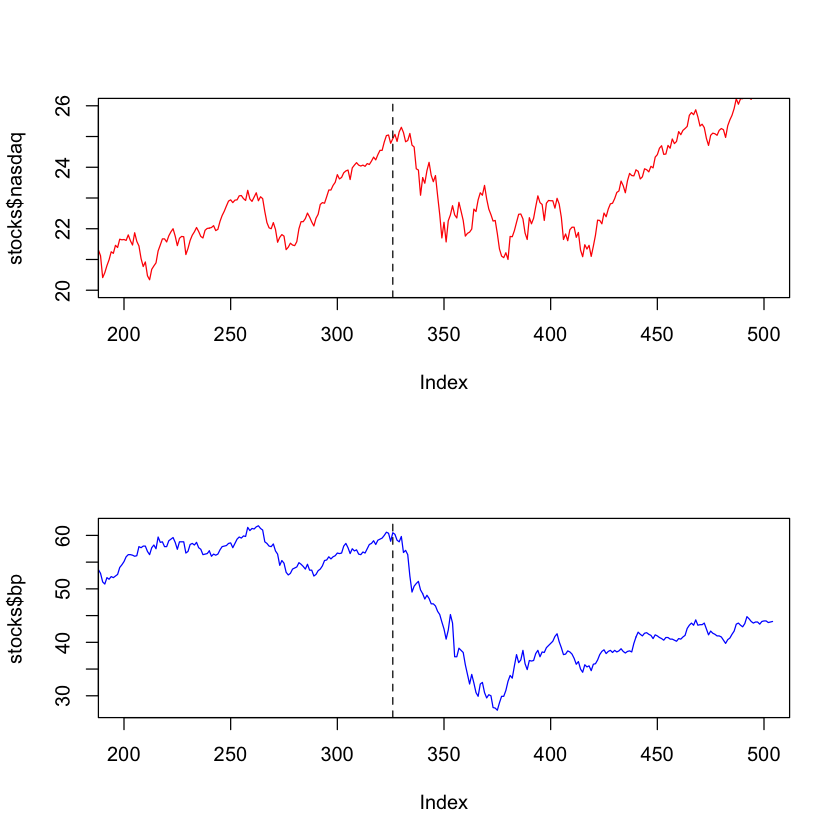

In [169]:
par(mfrow = c(2,1))
plot(stocks$nasdaq,col="red",type="l",xlim=c(200, 500), ylim=c(20, 26))
abline(v=326, lwd=1, lty=2)
plot(stocks$bp,col="blue",type="l", xlim=c(200, 500))
abline(v=326, lwd=1, lty=2)

## Causal Impact
[[go back to the top]](#Table-of-contents)

The `CausalImpact` package is based on BSTMs. BSTMs are used to build synthetic controls i.e. scenarios that would have occurred without the intervention. This technique allows one to estimate the causal effect and subsequent time evolution due to the intervention.

We give the package the following two inputs:

- a response time series and
- a set of control time series

`CausalImpact` then builds a BSTM which is used to predict the counterfactual. Note that one must be careful to choose a control series unaffected by the intervention.

In [176]:
library(CausalImpact)
stocks <- stocks[,c('bp', 'nasdaq')]
pre.period <- c(1, 325)
post.period <- c(326, 504)

In [179]:
impact <- CausalImpact(data = stocks, pre.period = pre.period, post.period = post.period)
summary(impact)

Posterior inference {CausalImpact}

                         Average        Cumulative    
Actual                   41             7250          
Prediction (s.d.)        57 (2.7)       10146 (480.6) 
95% CI                   [51, 62]       [9195, 11113] 
                                                      
Absolute effect (s.d.)   -16 (2.7)      -2896 (480.6) 
95% CI                   [-22, -11]     [-3863, -1945]
                                                      
Relative effect (s.d.)   -29% (4.7%)    -29% (4.7%)   
95% CI                   [-38%, -19%]   [-38%, -19%]  

Posterior tail-area probability p:   0.00106
Posterior prob. of a causal effect:  99.89384%

For more details, type: summary(impact, "report")



Warning message:
“Removed 504 rows containing missing values (geom_path).”Warning message:
“Removed 1008 rows containing missing values (geom_path).”

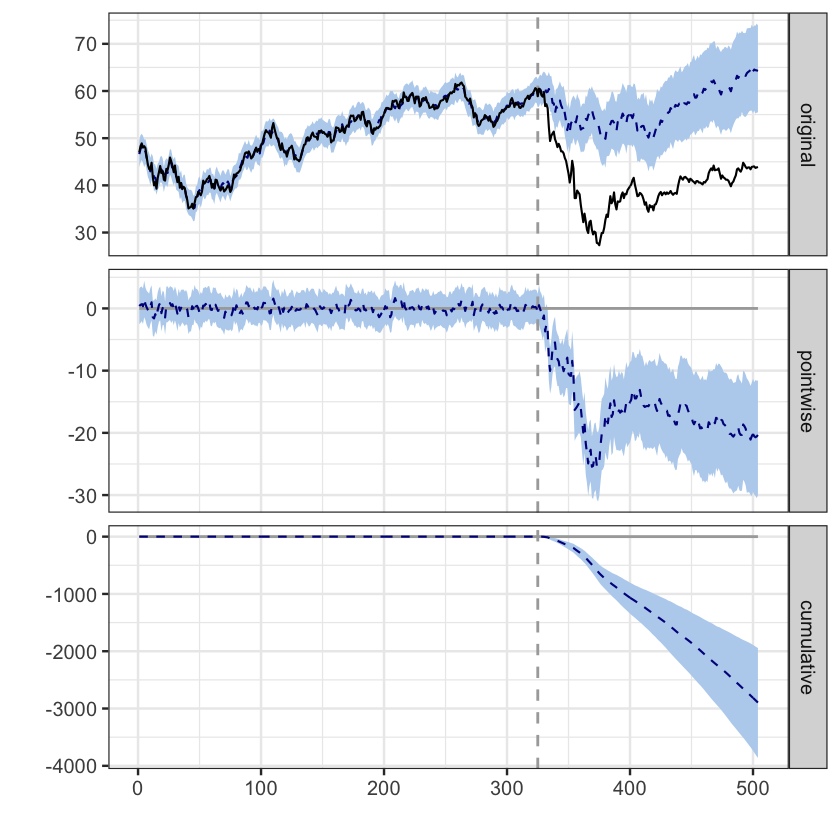

In [186]:
par(mfrow = c(1, 2))
plot(impact);

The difference between the data and the prediction post-intervention is the causal effect of the intervention. The three panels show respectively:
- The observed and predicted response on the original scale
- The difference between the two
- The individual causal effects added up 

### References

Ref.1: [Sengul,B.,Causal Impact and BSTS](http://www.batisengul.co.uk/post/causal-impact-and-bayesian-structural-time-series/)